In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
from scipy import stats,special
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import SymLogNorm
import math
import time
import h5py

import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

import innvestigate
import innvestigate.utils as iutils


import os

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


In [2]:
# Set default options for paper
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white',
         'figure.autolayout': True
         }
plt.rc('font', family='serif')
plt.rcParams.update(params)
plt.style.context('default')

## Useful Functions from Uli

In [3]:
def build_XY(features,label,dic):
    X = [dic[key] for key in features]
    Y = [dic[key] for key in label]
    return X,Y

In [4]:
def Get_LRP_Score(data,model,LRP_fct):
    
    # Strip model of softmax function for LRP
    model_ws = iutils.keras.graph.model_wo_softmax(model)
    
    # Build LRP analyzer
    lrp_analyzer = innvestigate.create_analyzer(LRP_fct, model_ws)
    lrp_score = [lrp_analyzer.analyze(ele) for ele in data]
    return lrp_score

In [5]:
def Confusion_Split(X,Y,pred,confidence_cut):
    ind_true_positive = np.argwhere((pred[:,0,1] > confidence_cut) & (Y[0][:,1] == 1))
    ind_true_negative = np.argwhere((pred[:,0,0] > confidence_cut) & (Y[0][:,0] == 1))
    ind_false_positive = np.argwhere((pred[:,0,1] > confidence_cut) & (Y[0][:,0] == 1))
    ind_false_negative = np.argwhere((pred[:,0,0] > confidence_cut) & (Y[0][:,1] == 1))
    
    LRP_tp = X[ind_true_positive]
    LRP_tn = X[ind_true_negative]
    LRP_fp = X[ind_false_positive]
    LRP_fn = X[ind_false_negative]
    return LRP_tp,LRP_tn,LRP_fp,LRP_fn

lrp_algorithms=['lrp', 'lrp.z', 'lrp.z_IB', 'lrp.epsilon', 'lrp.epsilon_IB', 'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1', 'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.z_plus', 'lrp.z_plus_fast', 'lrp.sequential_preset_a', 'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat', 'lrp.sequential_preset_b_flat']

## Profile Plot Function from Garv

In [6]:
def plot_profile(sig_hist, bkg_hist, tp_sig, tp_bkg, tp_relevance, fp_relevance, bins, xlabel, feature, maxy, title, model):
    '''
    sig_hist: array of a variable for signal that will be plotted as hist on top
    bkg_hist: array of a variable for bkg that will be plotted as hist on top
    tp_sig: array of a variable for true positive (signal) case
    tn_sig: array of a variable for true negatice (bkg) case
    tp_relevance: array of relevance for a variable for true positive (signal) case
    tn_relevance: array of relevance for a variable for true negative (bkg) case
    bins: number of bins
    xlabel: string of xlabel
    maxy: y range for relevance plot (-maxy, maxy)
    '''
    fig=plt.figure(figsize=(6,7))
    gs=gridspec.GridSpec(3,1)
    ax1=fig.add_subplot(gs[:2,:])
    ax2=fig.add_subplot(gs[2,:])
    bin_means, bin_edges, binnumber = stats.binned_statistic(tp_sig.flatten(), tp_relevance.flatten(),
                                                             statistic='mean', bins=bins)
    bin_std, _, _ = stats.binned_statistic(tp_sig.flatten(), tp_relevance.flatten(), statistic='std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    ax2.plot(bin_centers,bin_means, '#1f77b4', lw=2,label='Signal')
    ax2.fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color = '#1f77b4', alpha = 0.2)
    bin_means, bin_edges, binnumber = stats.binned_statistic(tp_bkg.flatten(),fp_relevance.flatten(),
                                                             statistic='mean', bins=bins)
    bin_std, _, _ = stats.binned_statistic(tp_bkg.flatten(), fp_relevance.flatten(), statistic='std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    ax2.plot(bin_centers,bin_means, '#ff7f0e', lw=2,label='Background')
    ax2.fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color = '#ff7f0e', alpha = 0.2)
    ax1.hist(sig_hist, normed=False,weights = np.ones(len(sig_hist.flatten()))/len(sig_hist.flatten()),
             histtype='step', alpha=0.55, facecolor='#1f77b4', bins=bins, lw=2,
             label='Signal', hatch='/', edgecolor='k', fill=True)
    ax1.hist(bkg_hist, normed=False, weights = np.ones(len(bkg_hist.flatten()))/len(bkg_hist.flatten()),
            histtype='step',alpha=0.55, facecolor='#ff7f0e', bins=bins, lw=2,
            label='Background', hatch='\\', edgecolor='k', fill=True)
    minx= np.min([np.min(sig_hist.flatten()), np.min(bkg_hist.flatten())])
    maxx= np.max([np.max(sig_hist.flatten()), np.max(bkg_hist.flatten())])
    ax1.set_xlim(minx,maxx)
    ax1.legend(loc='upper center')
    ax1.set_ylabel('Density')
    ax1.set_title('LRP Profile of ' + title)
    ax2.set_ylabel('Relevance')
    ax2.set_xlabel(xlabel)
    ax2.set_xlim(minx,maxx)
    ax2.set_ylim(-maxy,maxy)
    ax2.plot([minx,maxx],[0,0],'--k')
    ax1.set_xticklabels([])
    plt.savefig('plots/' + model + feature + '.png')
    plt.show()

# My Useful Functions

In [7]:
def load_data(file, n, nex):
        data = np.load(file)
        batch = len(data['pt1'][1]) #if not toy model use 'jetconstPt_log' not 'pt1'
        features = [key for key in data.keys()]
        print(features)
        features = features[0:n + nex]
        X, Y = build_XY(features,['labels'],data)
        labels = data['labels']
        return X, Y, labels, features, batch

In [8]:
def rel_bar_plot(LRP_mean, features, names, title, model):
    fig, ax = plt.subplots(1,1)
    plt.bar(np.arange(len(features)),LRP_mean)
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(names, rotation=45, fontsize=18)
    ax.set_ylabel('Relevance')
    ax.set_title('Feature Significance for ' + title)
    plt.savefig('plots/' + model + 'featureBar.png')

In [65]:
def makeColorScatter(x_input, y_input, sig_color, bkg_color, title, model, xlabel, ylabel):
    colorlist_sig=sig_color[(Y[0][:,0]==1)].flatten()
    colorlist_bkg=bkg_color[(Y[0][:,1]==1)].flatten()
    fig, ax = plt.subplots(1,1)
    plt.scatter(x_input[(Y[0][:,0]==1)].flatten(), y_input[(Y[0][:,0]==1)].flatten(), c=colorlist_sig, cmap = 'Blues', label = "Signal", s = 6)
    plt.scatter(x_input[(Y[0][:,1]==1)].flatten(), y_input[(Y[0][:,1]==1)].flatten(), c=colorlist_bkg, cmap = 'Reds', label = "Background", s = 6)
    ax.set_xlabel(xlabel)
#     ax.set_ylim(0,0.35)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.savefig('plots/' + model + '.png')
    plt.show()

## CNN1D w/o XAUGS

In [10]:
X, Y, labels, features, batch = load_data(file = 'data/jetConstTest_overlap.npz', n = 6, nex = 0)
# Y = [np.where(Y[0] == 0, Y[0]+1, Y[0]-1)]
n_data = len(X[0])
n_feat = len(features)
model = keras.models.load_model('model/CNN1D_DO.h5')
model.summary()
results = model.evaluate(X, Y, verbose = 0)
print(results)

['pt1', 'pt2', 'dtheta1', 'dtheta2', 'dphi1', 'dphi2', 'theta', 'r1', 'r2', 'z', 'labels']
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 10, 1)        0                          

[0.09147617139816284, 0.09147617139816284, 0.971]


In [11]:
# Reshape Data, for easier application of LRP algorithm
confidence_cut = 0.7
X_lrp = [[X[i][j].reshape(1,batch,1) for i in range(len(features))] for j in range(n_data)]
pred = np.array([model.predict(ele) for ele in X_lrp])
Y_lrp = Y

In [12]:
LRP_full = Get_LRP_Score(X_lrp,model,'lrp.sequential_preset_a')  

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [13]:
LRP_full = np.array(LRP_full).reshape(n_data, n_feat, batch)
LRP_norm = np.where(np.repeat(np.amax(np.abs(LRP_full),axis = (1,2)),batch*n_feat).reshape(LRP_full.shape) >0,
            (LRP_full/np.repeat(np.amax(np.abs(LRP_full),axis = (1,2)),n_feat*batch).reshape(LRP_full.shape)),0)
LRP_mean = [np.mean(LRP_norm[:,i]) for i in range(len(features))]

In [ ]:
LRP_diff = np.array(LRP_norm).reshape(len(LRP_norm),n_feat,batch)
LRP_sum = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full])
X_diff = np.array(X_lrp).reshape(len(LRP_diff),n_feat,batch)
X_tp, X_tn, X_fp, X_fn =Confusion_Split(X_diff, Y_lrp,
                                                     pred,
                                                     confidence_cut)
LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_diff,
                                                     Y_lrp,
                                                     pred,
                                                     confidence_cut)
print(LRP_tp.squeeze()[:,1].shape)

In [ ]:
names = [r'$z_{const,1}$', r'$z_{const,2}$', r'd$\theta_1$', r'd$\theta_2$', r'd$\phi_1$', r'd$\phi_2$']
rel_yrange = [2, 2, 0.1, 0.1, 0.5, 0.5]
for i in range(len(features)):
    plot_profile(X_diff[:,i][(Y[0][:,1]==1)].flatten(),
                X_diff[:,i][(Y[0][:,1]==0)].flatten(),
                X_tp.squeeze()[:,i], X_tn.squeeze()[:,i],
                LRP_tp.squeeze()[:,i], LRP_tn.squeeze()[:,i], 50, names[i], features[i], rel_yrange[i],
                 'Toy 1D CNN','CNN_1D')

In [ ]:
rel_bar_plot(LRP_mean, features, names, 'Toy 1D CNN','CNN1D')

# CNN1D w/ XAUGS

In [ ]:
X, Y, labels, features, batch= load_data(file = 'data/jetConstTest_overlap.npz', n = 6, nex = 4)
# Y = [np.where(Y[0] == 0, Y[0]+1, Y[0]-1)]
n_data = len(X[0])
n_xaug = len(features) - n_feat
model = keras.models.load_model('model/CNN1D_XAUG.h5')
model.summary()
results = model.evaluate(X, Y, verbose = 0)
print(results)

In [ ]:
batch = len(X[0][0])
# Reshape Data, for easier application of LRP algorithm
confidence_cut = 0.7
X_lrp = [[X[i][j] for i in range(len(features))] for j in range(n_data)]
for i in range(len(features)):
    for j in range(n_data):
        if i < n_feat:
            X_lrp[j][i] = X_lrp[j][i].reshape(1,batch,1)
        else:
            X_lrp[j][i] = X_lrp[j][i].reshape(1,)
pred = np.array([model.predict(ele) for ele in X_lrp])
Y_lrp = Y
names = names + [r'$\theta$', r'$r_1$', r'$r_2$', r'$z$']

In [19]:
LRP_full = Get_LRP_Score(X_lrp,model,'lrp.sequential_preset_a')  

In [20]:
LRP_list = np.array([LRP_full[i][0:n_feat] for i in range(n_data)]).reshape(n_data, n_feat, batch)
LRP_XAUG = np.array([LRP_full[i][n_feat:(n_feat+n_xaug)] for i in range(n_data)]).reshape(n_data, n_xaug)
evemax = np.where(np.max(np.abs(LRP_list), axis=(1,2))> np.max(np.abs(LRP_XAUG), axis=1),
                  np.max(np.abs(LRP_list), axis=(1,2)), np.max(np.abs(LRP_XAUG), axis=1))
LRP_list_norm = np.where(np.repeat(np.amax(np.abs(LRP_list),axis = (1,2)),batch*n_feat).reshape(LRP_list.shape) >0,
                                LRP_list/np.repeat(evemax,n_feat*batch).reshape(LRP_list.shape),0)
print(LRP_list_norm.shape)
LRP_XAUG_norm = np.where(np.repeat(np.amax(np.abs(LRP_XAUG), axis = 1), n_xaug).reshape(LRP_XAUG.shape) >0,
                              LRP_XAUG/np.repeat(evemax, n_xaug).reshape(LRP_XAUG.shape),0)
LRP_sum = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full])
X_list = np.array([X_lrp[i][0:n_feat] for i in range(n_data)]).reshape(n_data, n_feat, batch)
X_XAUG = np.array([X_lrp[i][n_feat:(n_feat+n_xaug)] for i in range(n_data)]).reshape(n_data, n_xaug)
X_list_tp, X_list_tn, X_list_fp, X_list_fn =Confusion_Split(X_list, Y_lrp,
                                                     pred,
                                                     confidence_cut)
LRP_list_tp, LRP_list_tn, LRP_list_fp, LRP_list_fn = Confusion_Split(LRP_list_norm,
                                                     Y_lrp,
                                                     pred,
                                                     confidence_cut)
X_XAUG_tp, X_XAUG_tn, X_XAUG_fp, X_XAUG_fn =Confusion_Split(X_XAUG, Y_lrp,
                                                     pred,
                                                     confidence_cut)
LRP_XAUG_tp, LRP_XAUG_tn, LRP_XAUG_fp, LRP_XAUG_fn = Confusion_Split(LRP_XAUG_norm,
                                                     Y_lrp,
                                                     pred,
                                                     confidence_cut)

(20000, 6, 10)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


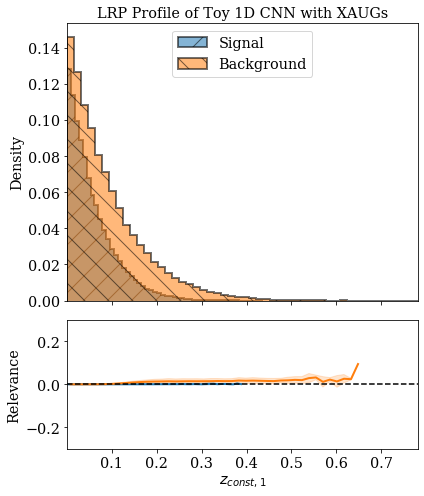

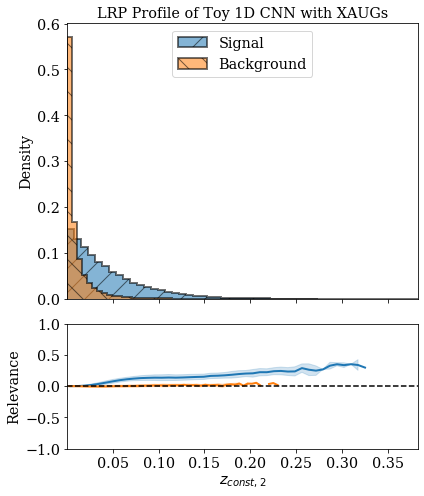

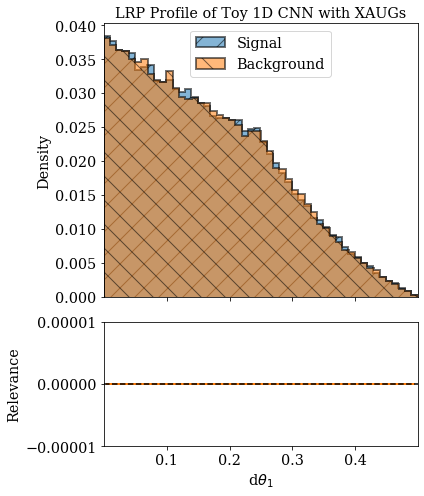

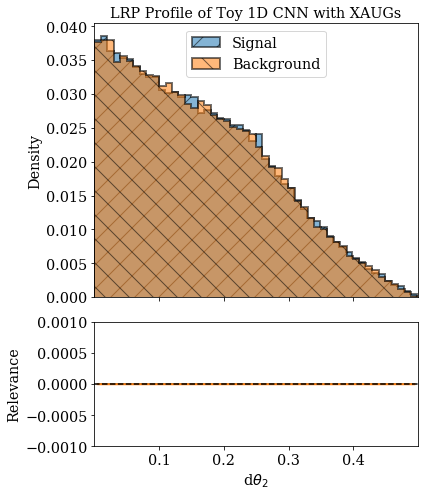

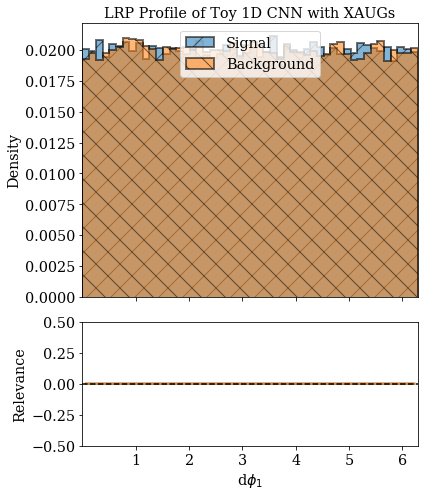

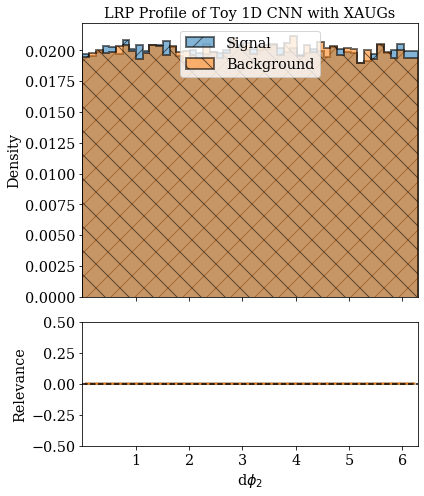

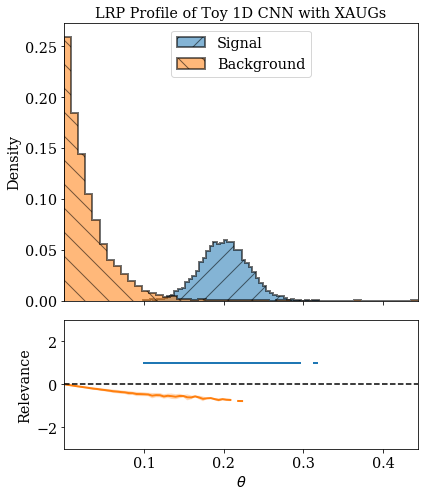

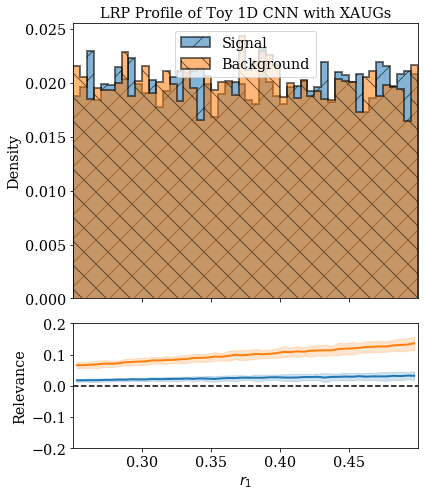

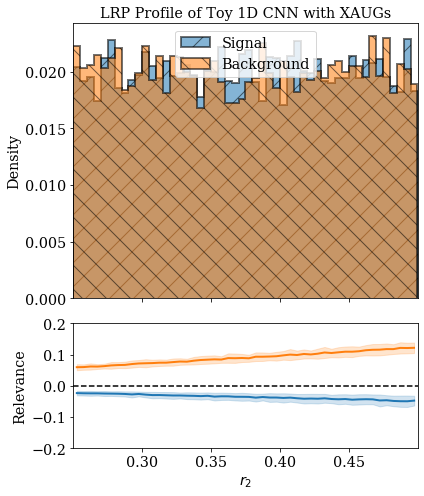

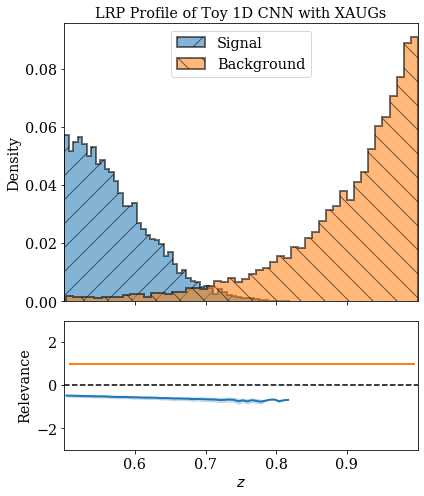

In [21]:
rel_list_ys = [0.3, 1.0, 0.00001, 0.001, 0.5, 0.5]
rel_XAUG_ys = [3, 0.2, 0.2, 3]
for i in range(n_feat):
    plot_profile(X_list[:,i][(Y[0][:,1]==1)].flatten(),
                X_list[:,i][(Y[0][:,1]==0)].flatten(),
                X_list_tp.squeeze()[:,i], X_list_tn.squeeze()[:,i],
                LRP_list_tp.squeeze()[:,i], LRP_list_tn.squeeze()[:,i], 50, names[i], features[i], rel_list_ys[i],
                 'Toy 1D CNN with XAUGs', 'CNN1D_XAUG')
for i in range(n_xaug):
    plot_profile(X_XAUG[:,i][(Y[0][:,1]==1)].flatten(),
                X_XAUG[:,i][(Y[0][:,1]==0)].flatten(),
                X_XAUG_tp.squeeze()[:,i], X_XAUG_tn.squeeze()[:,i],
                LRP_XAUG_tp.squeeze()[:,i], LRP_XAUG_tn.squeeze()[:,i], 50, names[i+n_feat], features[i+n_feat],
                 rel_XAUG_ys[i],'Toy 1D CNN with XAUGs', 'CNN1D_XAUG')

10


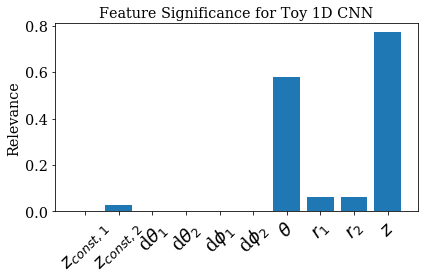

In [22]:
LRP_mean = np.hstack([np.mean(np.abs(LRP_list_norm), axis = (0,2)),np.mean(np.abs(LRP_XAUG_norm), axis = 0)])
print(len(LRP_mean))
rel_bar_plot(LRP_mean, features, names, 'Toy 1D CNN', 'CNN1D_XAUG')
plt.tight_layout()

# Make Theta vs. Z plots

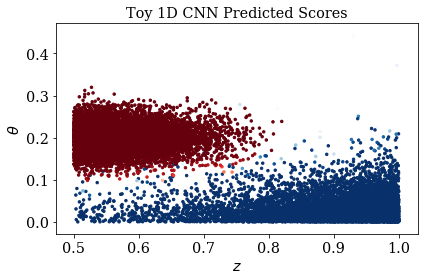

In [23]:
makeColorScatter(X_XAUG[:,3], X_XAUG[:,0], pred.squeeze()[:,0], pred.squeeze()[:,1], 'Toy 1D CNN Predicted Scores', 'CNN1D',
                 r'$z$', r'$\theta$')
                 

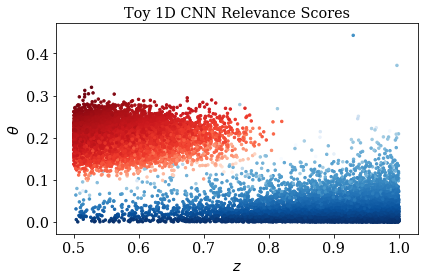

In [24]:
makeColorScatter(X_XAUG[:,3], X_XAUG[:,0], LRP_XAUG_norm.squeeze()[:,3]+LRP_XAUG_norm.squeeze()[:,0],
                 LRP_XAUG_norm.squeeze()[:,3]+LRP_XAUG_norm.squeeze()[:,0],'Toy 1D CNN Relevance Scores', 'LRP_CNN1D',
                r'$z$', r'$\theta$')

# RNN w/ List Only

In [25]:
X, Y, labels, features, batch = load_data(file = 'data/jetConstTest_overlap.npz', n = 6, nex = 0)
n_data = len(X[0])
n_feat = len(features)
model = keras.models.load_model('model/RNN.h5')
model.summary()
results = model.evaluate(X, Y, verbose = 0)
print(results)

['pt1', 'pt2', 'dtheta1', 'dtheta2', 'dphi1', 'dphi2', 'theta', 'r1', 'r2', 'z', 'labels']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________

In [26]:
# Reshape Data, for easier application of LRP algorithm
confidence_cut = 0.7
X_lrp = [[X[i][j].reshape(1,batch,1) for i in range(n_feat)] for j in range(n_data)]
pred = np.array([model.predict(ele) for ele in X_lrp])
Y_lrp = Y

In [27]:
LRP_full = Get_LRP_Score(X_lrp,model,'lrp.epsilon')  

/opt/conda/lib/python3.7/site-packages/innvestigate/analyzer/base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.recurrent.GRU object at 0x7fb30d7b8240>, <keras.layers.recurrent.GRU object at 0x7fb30d7b4438>, <keras.layers.recurrent.GRU object at 0x7fb30d7b4908>]
  warnings.warn(tmp_message)


In [28]:
LRP_full = np.array(LRP_full).reshape(n_data, n_feat, batch)
LRP_norm = np.where(np.repeat(np.amax(np.abs(LRP_full),axis = (1,2)),n_feat*batch).reshape(LRP_full.shape) >0,
                                (LRP_full/np.repeat(np.amax(LRP_full,axis = 
                                                            (1,2)),n_feat*batch).reshape(LRP_full.shape)),0)
LRP_mean = [np.mean(np.abs(LRP_norm[:,i])) for i in range(n_feat)]

In [29]:
LRP_diff = np.array(LRP_norm).reshape(len(LRP_norm),n_feat,batch)
LRP_sum = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full])
print(LRP_sum.shape)
X_diff = np.array(X_lrp).reshape(len(LRP_diff),n_feat,batch)
X_tp, X_tn, X_fp, X_fn =Confusion_Split(X_diff, Y_lrp,
                                                     pred,
                                                     confidence_cut)
LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_diff,
                                                     Y_lrp,
                                                     pred,
                                                     confidence_cut)
print(LRP_tp.squeeze()[:,1].shape)

(20000, 6)
(9919, 10)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


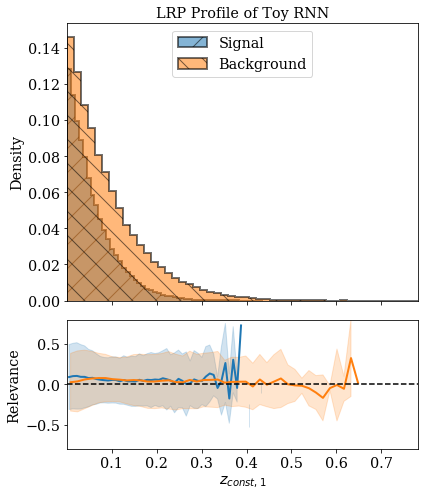

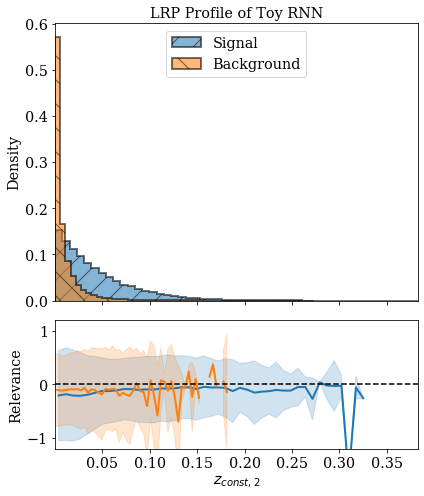

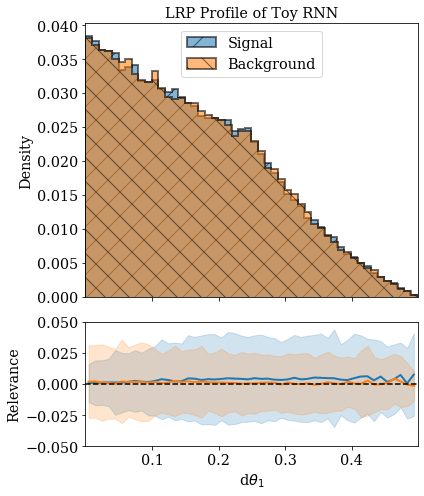

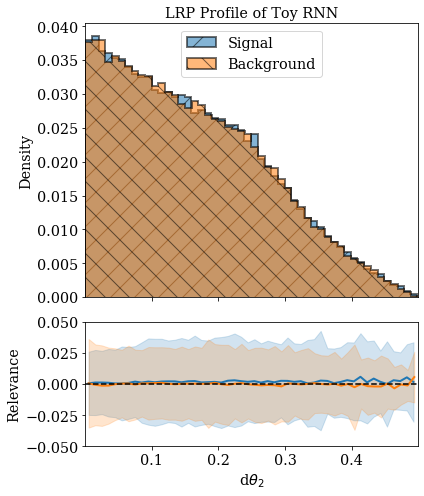

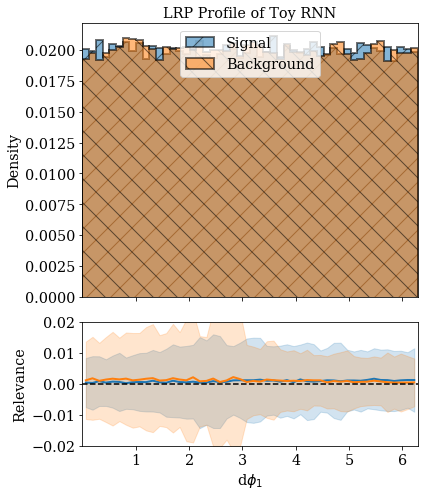

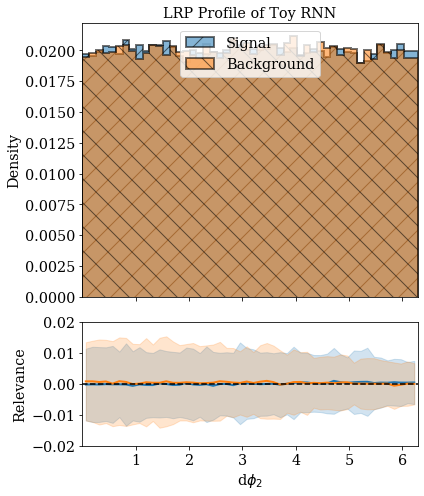

In [30]:
names = [r'$z_{const,1}$', r'$z_{const,2}$', r'd$\theta_1$', r'd$\theta_2$', r'd$\phi_1$', r'd$\phi_2$']
rel_yrange = [0.8, 1.2, 0.05, 0.05, 0.02, 0.02]
for i in range(n_feat):
    plot_profile(X_diff[:,i][(Y[0][:,1]==1)].flatten(),
                X_diff[:,i][(Y[0][:,1]==0)].flatten(),
                X_tp.squeeze()[:,i], X_tn.squeeze()[:,i],
                LRP_tp.squeeze()[:,i], LRP_tn.squeeze()[:,i], 50, names[i], features[i], rel_yrange[i],
                 'Toy RNN', 'RNN')

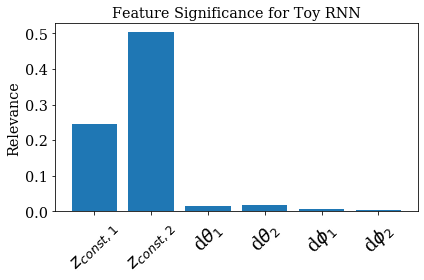

In [31]:
rel_bar_plot(LRP_mean, features, names, 'Toy RNN', 'RNN')

# RNN w/ XAUGS

In [32]:
X, Y, labels, features, batch = load_data(file = 'data/jetConstTest_overlap.npz', n = 6, nex = 4)
n_data = len(X[0])
n_xaug = len(features) - n_feat
model = keras.models.load_model('model/RNN_2_XAUG.h5')
model.summary()
results = model.evaluate(X, Y, verbose = 0)
print(results)

['pt1', 'pt2', 'dtheta1', 'dtheta2', 'dphi1', 'dphi2', 'theta', 'r1', 'r2', 'z', 'labels']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 10, 1)        0                                            
__________________

In [33]:
batch = len(X[0][0])
# Reshape Data, for easier application of LRP algorithm
confidence_cut = 0.7
X_lrp = [[X[i][j] for i in range(len(features))] for j in range(n_data)]
for i in range(len(features)):
    for j in range(n_data):
        if i < n_feat:
            X_lrp[j][i] = X_lrp[j][i].reshape(1,batch,1)
        else:
            X_lrp[j][i] = X_lrp[j][i].reshape(1,)
pred = np.array([model.predict(ele) for ele in X_lrp])
Y_lrp = Y
names = names + [r'$\theta$', r'$r_1$', r'$r_2$', r'$z$']

In [34]:
LRP_full = Get_LRP_Score(X_lrp,model,'lrp.epsilon')  

/opt/conda/lib/python3.7/site-packages/innvestigate/analyzer/base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.recurrent.GRU object at 0x7fb30f1ed8d0>, <keras.layers.recurrent.GRU object at 0x7fb32abcf208>, <keras.layers.recurrent.GRU object at 0x7fb32abcf6d8>]
  warnings.warn(tmp_message)


In [35]:
LRP_list = np.array([LRP_full[i][0:n_feat] for i in range(n_data)]).reshape(n_data, n_feat, batch)
LRP_XAUG = np.array([LRP_full[i][n_feat:(n_feat+n_xaug)] for i in range(n_data)]).reshape(n_data, n_xaug)
evemax = np.where(np.max(np.abs(LRP_list), axis=(1,2))> np.max(np.abs(LRP_XAUG), axis=1),
                  np.max(np.abs(LRP_list), axis=(1,2)), np.max(np.abs(LRP_XAUG), axis=1))
LRP_list_norm = np.where(np.repeat(np.amax(np.abs(LRP_list),axis = (1,2)),batch*n_feat).reshape(LRP_list.shape) >0,
                                LRP_list/np.repeat(evemax,batch*n_feat).reshape(LRP_list.shape),0)
print(LRP_list_norm.shape)
LRP_XAUG_norm = np.where(np.repeat(np.amax(np.abs(LRP_XAUG), axis = 1), n_xaug).reshape(LRP_XAUG.shape) >0,
                              LRP_XAUG/np.repeat(evemax, n_xaug).reshape(LRP_XAUG.shape),0)
LRP_sum = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full])
X_list = np.array([X_lrp[i][0:n_feat] for i in range(n_data)]).reshape(n_data, n_feat, batch)
X_XAUG = np.array([X_lrp[i][n_feat:(n_feat+n_xaug)] for i in range(n_data)]).reshape(n_data, n_xaug)
X_list_tp, X_list_tn, X_list_fp, X_list_fn =Confusion_Split(X_list, Y_lrp,
                                                     pred,
                                                     confidence_cut)
LRP_list_tp, LRP_list_tn, LRP_list_fp, LRP_list_fn = Confusion_Split(LRP_list_norm,
                                                     Y_lrp,
                                                     pred,
                                                     confidence_cut)
X_XAUG_tp, X_XAUG_tn, X_XAUG_fp, X_XAUG_fn =Confusion_Split(X_XAUG, Y_lrp,
                                                     pred,
                                                     confidence_cut)
LRP_XAUG_tp, LRP_XAUG_tn, LRP_XAUG_fp, LRP_XAUG_fn = Confusion_Split(LRP_XAUG_norm,
                                                     Y_lrp,
                                                     pred,
                                                     confidence_cut)

(20000, 6, 10)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


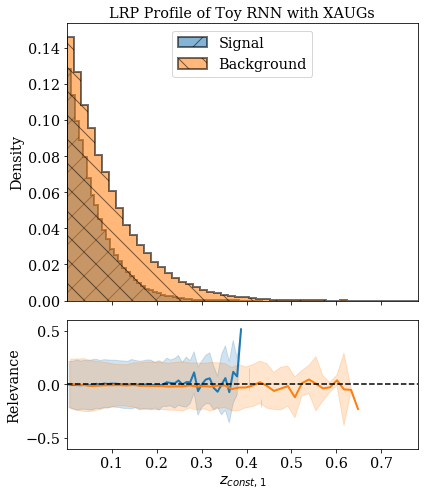

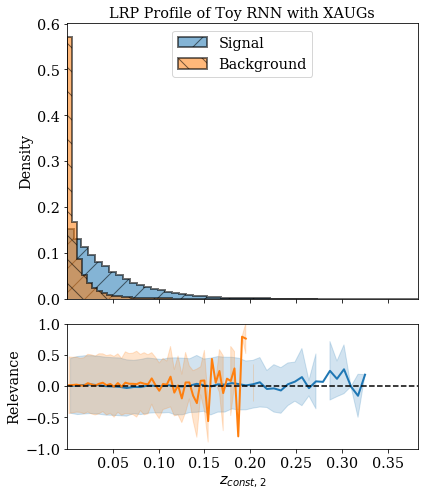

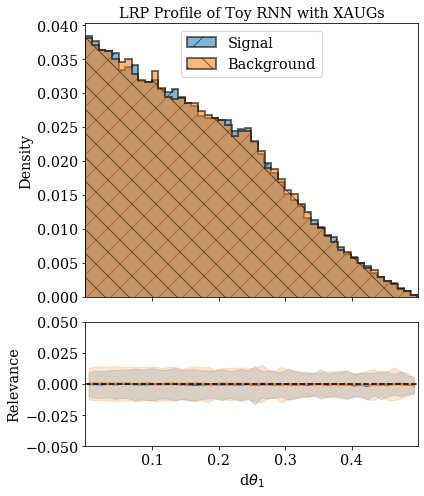

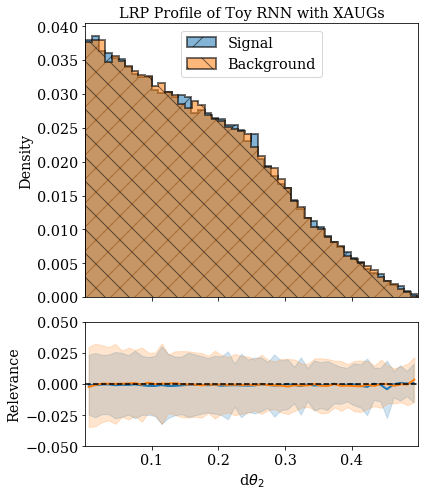

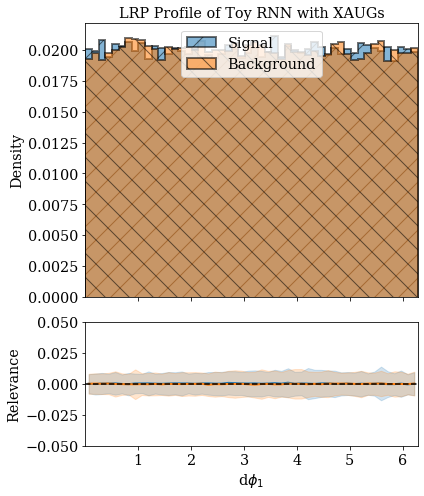

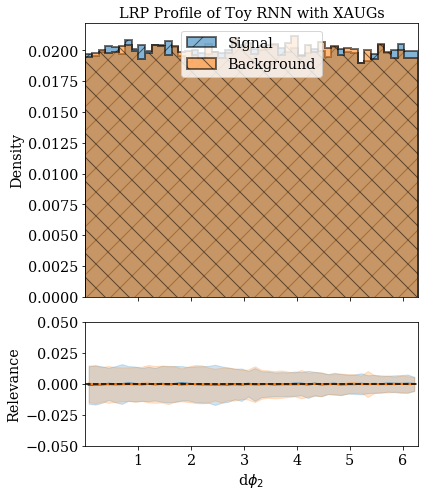

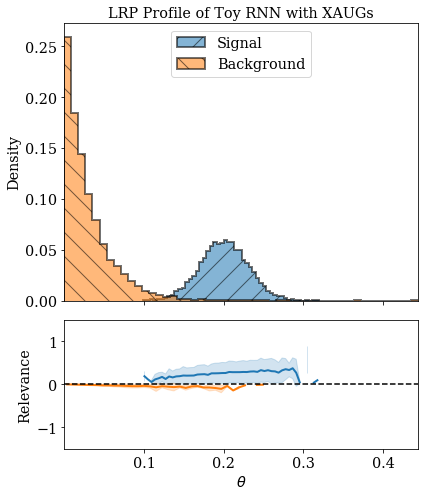

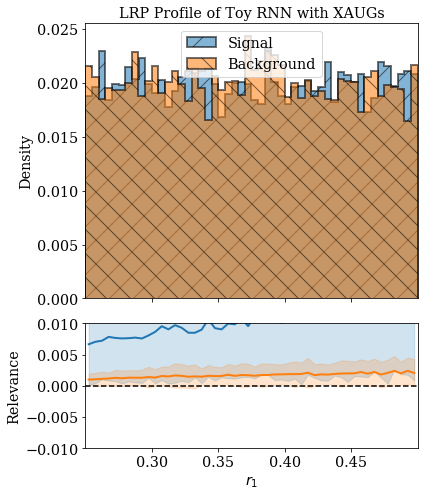

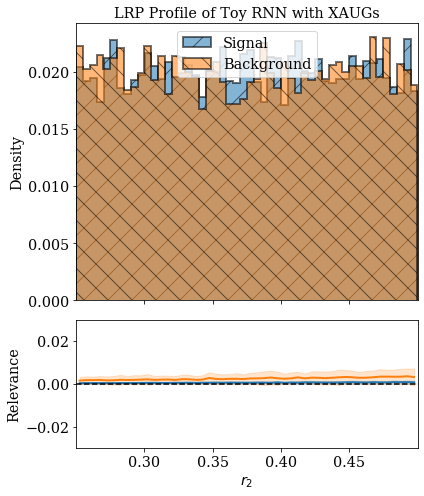

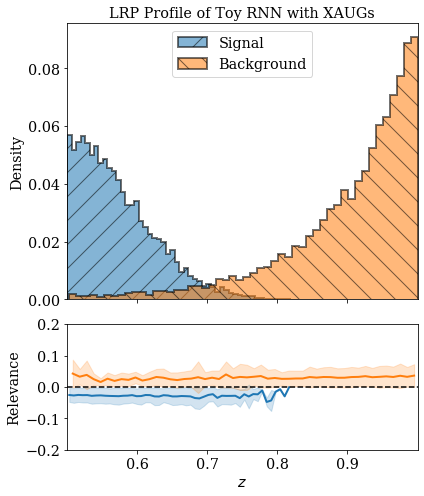

In [36]:
rel_list_ys = [0.6, 1.0, 0.05, 0.05, 0.05, 0.05]
rel_XAUG_ys = [1.5, 0.01, 0.03, 0.2]
for i in range(n_feat):
    plot_profile(X_list[:,i][(Y[0][:,1]==1)].flatten(),
                X_list[:,i][(Y[0][:,1]==0)].flatten(),
                X_list_tp.squeeze()[:,i], X_list_tn.squeeze()[:,i],
                LRP_list_tp.squeeze()[:,i], LRP_list_tn.squeeze()[:,i], 50, names[i], features[i], rel_list_ys[i],
                 'Toy RNN with XAUGs', 'RNN_XAUG')
for i in range(n_xaug):
    plot_profile(X_XAUG[:,i][(Y[0][:,1]==1)].flatten(),
                X_XAUG[:,i][(Y[0][:,1]==0)].flatten(),
                X_XAUG_tp.squeeze()[:,i], X_XAUG_tn.squeeze()[:,i],
                LRP_XAUG_tp.squeeze()[:,i], LRP_XAUG_tn.squeeze()[:,i], 50, names[i+n_feat], features[i+n_feat], rel_XAUG_ys[i],
                 'Toy RNN with XAUGs', 'RNN_XAUG')

10


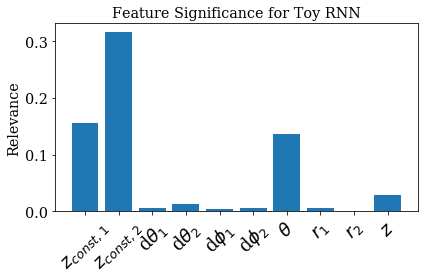

In [37]:
LRP_mean = np.hstack([np.mean(np.abs(LRP_list_norm), axis = (0,2)),np.mean(np.abs(LRP_XAUG_norm), axis = 0)])
print(len(LRP_mean))
rel_bar_plot(LRP_mean, features, names, 'Toy RNN', 'RNN')

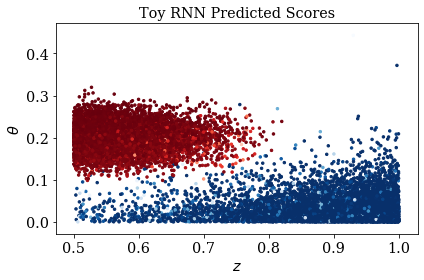

In [73]:
makeColorScatter(X_XAUG[:,3], X_XAUG[:,0], pred.squeeze()[:,0], pred.squeeze()[:,1], 'Toy RNN Predicted Scores', 'RNN_z_theta',
                 r'$z$', r'$\theta$')

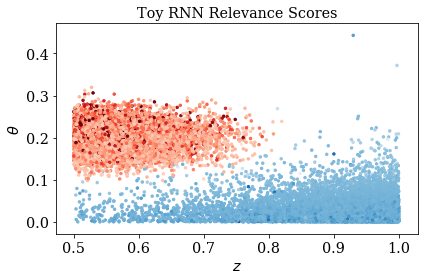

In [74]:
makeColorScatter(X_XAUG[:,3], X_XAUG[:,0], LRP_XAUG_norm.squeeze()[:,3]+LRP_XAUG_norm.squeeze()[:,0],
                 LRP_XAUG_norm.squeeze()[:,3]+LRP_XAUG_norm.squeeze()[:,0], 'Toy RNN Relevance Scores',
                 'LRP_RNN_z_theta', r'$z$', r'$\theta$')

['pt1', 'pt2', 'dtheta1', 'dtheta2', 'dphi1', 'dphi2', 'theta', 'r1', 'r2', 'z']
(20000,)


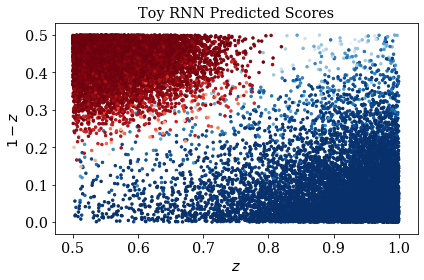

In [75]:
print(features)
print(pred.squeeze()[:,0].shape)
makeColorScatter(np.sum(X_list[:,0], axis = 1), np.sum(X_list[:,1], axis = 1), pred.squeeze()[:,0],
                 pred.squeeze()[:,1], 'Toy RNN Predicted Scores', 'RNN_zvsz',
                 r'$z$', r'$1-z$')

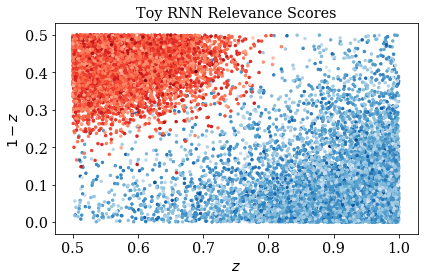

In [79]:
makeColorScatter(np.sum(X_list[:,0], axis = 1), np.sum(X_list[:,1], axis = 1),
                 np.sum(LRP_list_norm.squeeze()[:,0]+LRP_list_norm.squeeze()[:,1], axis = 1),
                 np.sum(LRP_list_norm.squeeze()[:,1]+LRP_list_norm.squeeze()[:,0], axis = 1),
                 'Toy RNN Relevance Scores','LRP_RNN_zvsz', r'$z$', r'$1-z$')

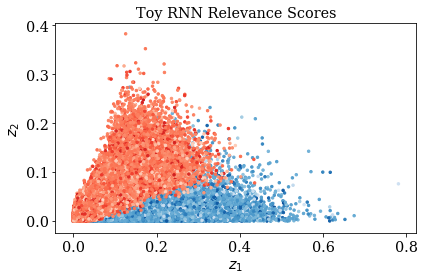

In [80]:
makeColorScatter(X_list[:,0], X_list[:,1], LRP_list_norm.squeeze()[:,0]+LRP_list_norm.squeeze()[:,1],
                 LRP_list_norm.squeeze()[:,1]+LRP_list_norm.squeeze()[:,0],
                 'Toy RNN Relevance Scores','LRP_RNN_z1vsz2', r'$z_1$', r'$z_2$')